In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.aparent_deconv_conv_generator_concat_alllayers_regressor import load_generator_network
from definitions.predictor.aparent import load_saved_predictor

Using TensorFlow backend.


In [2]:

entropy_anneal_coeff = K.variable(0.)
entropy_anneal_func = lambda alpha, epoch: 1.

#Define target isoform loss function
def get_isoform_loss(isoform_start=80, isoform_end=115, use_start=0, use_end=70, use_target_bits=1.8, cse_start=70, cse_end=76, cse_target_bits=1.8, dse_start=76, dse_end=125, dse_target_bits=1.8, entropy_weight=0.0, similarity_weight=0.0, punish_dn_cse=0.0, punish_up_c=0.0, punish_dn_c=0.0, punish_up_g=0.0, punish_dn_g=0.0, punish_up_aa=0.0, punish_dn_aa=0.0) :
    
    masked_use_entropy_mse = get_target_entropy_sme_masked(pwm_start=use_start, pwm_end=use_end, target_bits=use_target_bits)
    cse_entropy_mse = get_target_entropy_sme(pwm_start=cse_start, pwm_end=cse_end, target_bits=cse_target_bits)
    masked_dse_entropy_mse = get_target_entropy_sme_masked(pwm_start=dse_start, pwm_end=dse_end, target_bits=dse_target_bits)
    
    punish_dn_cse_func = get_punish_cse(pwm_start=74, pwm_end=dse_end)
    
    punish_up_c_func = get_punish_c(pwm_start=use_start, pwm_end=use_end)
    punish_dn_c_func = get_punish_c(pwm_start=dse_start, pwm_end=dse_end)
    
    punish_up_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    punish_dn_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    
    punish_up_aa_func = get_punish_aa(pwm_start=use_start, pwm_end=use_end)
    punish_dn_aa_func = get_punish_aa(pwm_start=dse_start, pwm_end=dse_end)
    
    pwm_sample_entropy_func = get_pwm_margin_sample_entropy_masked(pwm_start=70-60, pwm_end=76+60, margin=0.35, shift_1_nt=True) #, margin=0.5
    
    extra_sim = np.ones((len(target_isos), 1, 205, 4, 1))
    for i in range(len(target_isos)) :
        extra_sim[i, 0, 70-4:76, :, 0] = 0.0
    
    def loss_func(loss_tensors) :
        _, _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, iso_logit_true, iso_true, iso_pred, cut_pred, iso_score_pred, cut_score_pred = loss_tensors
        
        #Create target isoform with sample axis
        iso_true = K.tile(K.expand_dims(iso_true, axis=-1), (1, K.shape(sampled_pwm_1)[1], 1))
        
        #Aggregate total predicted isoform abundance
        #iso_pred = K.expand_dims(K.sum(cut_pred[..., isoform_start:isoform_end], axis=-1), axis=-1)

        #Specify costs
        iso_loss = 2.0 * K.mean(symmetric_sigmoid_kl_divergence(iso_true, iso_pred), axis=1)
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * K.mean(punish_dn_cse_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_c * K.mean(punish_dn_c_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_g * K.mean(punish_up_g_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_g * K.mean(punish_dn_g_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm_1), axis=1)
        
        
        extra_sims = K.constant(extra_sim)
        extra_sim_mask = K.gather(extra_sims, sequence_class[:, 0])
        extra_sim_mask = K.tile(extra_sim_mask, (1, K.shape(sampled_pwm_1)[1], 1, 1, 1))
        
        entropy_loss = entropy_anneal_coeff * entropy_weight * (masked_use_entropy_mse(pwm_1, mask) + cse_entropy_mse(pwm_1) + masked_dse_entropy_mse(pwm_1, mask))
        entropy_loss += similarity_weight * K.mean(pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask * extra_sim_mask), axis=1)
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return total_loss
    
    return loss_func

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

#Function for running GENESIS
def run_genesis(sequence_templates, loss_func, library_contexts, batch_size=32, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False)

    #Build Predictor Network and hook it on the generator PWM output tensor
    _, pwm_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=1, eval_mode='pwm')
    _, sample_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')

    for layer in pwm_predictor.layers :
        if 'aparent' in layer.name :
            layer.name += "_pwmversion"
    
    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, pwm_loss_model = build_loss_model(pwm_predictor, loss_func)
    _, sample_loss_model = build_loss_model(sample_predictor, loss_func)
    
    dual_loss_out = Lambda(lambda x: 0.5 * x[0] + 0.5 * x[1])([pwm_loss_model.outputs[0], sample_loss_model.outputs[0]])

    loss_model = Model(inputs=pwm_loss_model.inputs, outputs=dual_loss_out)
    
    #Specify Optimizer to use
    #opt = keras.optimizers.SGD(lr=0.1)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

    #Specify callback entities
    callbacks =[
        #EarlyStopping(monitor='loss', min_delta=0.001, patience=20, verbose=0, mode='auto'),
        #SeqPropMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=True, cse_start_pos=70, isoform_start=target_cut, isoform_end=target_cut+1, pwm_start=70-40, pwm_end=76+50, sequence_template=sequence_template, plot_pwm_indices=[0])
        EpochVariableCallback(entropy_anneal_coeff, entropy_anneal_func)
    ]

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)), #Dummy training example
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks
    )

    return generator, sample_predictor, train_history



In [3]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
model_path = os.path.join(save_dir, model_name)

In [4]:

sequence_templates = [
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    #'CTTCCGATCTCTCGCTCTTTCTATGGCATTCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNANNAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCTGTCGTCGTGGGTGTCGAAAATGAAATAAAACAAGTCAATTGCGTAGTTTATTCAGACGTACCCCGTGGACCTAC'
]

library_contexts = [
    'simple',
    #'doubledope'
]


In [ ]:
#Train APA Cleavage GENESIS Network

print("Training GENESIS (Max Isoforms of All libraries)")

#Number of PWMs to generate per objective
batch_size = 36
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 10
#Number of epochs per objective to optimize
n_epochs = 70
#Number of steps (grad updates) per epoch
steps_per_epoch = 500

loss = get_isoform_loss(
    use_start=22,
    use_end=70,
    use_target_bits=1.95,
    cse_start=70,
    cse_end=76,
    cse_target_bits=1.95,
    dse_start=76,
    dse_end=121,
    dse_target_bits=1.95,
    entropy_weight=2.0,
    similarity_weight=5.0,
    punish_dn_cse=1.0,
    punish_up_c=0.015,
    punish_dn_c=0.0001,
    punish_up_g=0.0001,
    punish_dn_g=0.0001,
    punish_up_aa=0.0025,
    punish_dn_aa=0.025
)

genesis_generator, genesis_predictor, train_history = run_genesis(sequence_templates, loss, library_contexts, batch_size, n_samples, n_epochs, steps_per_epoch)


In [ ]:
genesis_generator.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
genesis_generator.get_layer('lambda_rand_input_1').function = lambda inp: inp
genesis_generator.get_layer('lambda_rand_input_2').function = lambda inp: inp
genesis_generator.get_layer('lambda_rand_iso_1').function = lambda inp: inp

genesis_predictor.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
genesis_predictor.get_layer('lambda_rand_input_1').function = lambda inp: inp
genesis_predictor.get_layer('lambda_rand_input_2').function = lambda inp: inp
genesis_predictor.get_layer('lambda_rand_iso_1').function = lambda inp: inp

In [ ]:
# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'genesis_isoform_regression_pwm_and_multisample_marginsimilarity_hardersimilarity_sym_kl_concat_punishupc_marginsim_035_simple_generator.h5'
model_path = os.path.join(save_dir, model_name)
genesis_generator.save(model_path)
print('Saved trained model at %s ' % model_path)

model_name = 'genesis_isoform_regression_pwm_and_multisample_marginsimilarity_hardersimilarity_sym_kl_concat_punishupc_marginsim_035_simple_predictor.h5'
model_path = os.path.join(save_dir, model_name)
genesis_predictor.save(model_path)
print('Saved trained model at %s ' % model_path)

In [5]:
#(Re-)Load GENESIS model

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'genesis_isoform_regression_pwm_and_multisample_marginsimilarity_hardersimilarity_sym_kl_concat_punishupc_marginsim_035_simple_generator.h5'
model_path = os.path.join(save_dir, model_name)

generator = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'genesis_isoform_regression_pwm_and_multisample_marginsimilarity_hardersimilarity_sym_kl_concat_punishupc_marginsim_035_simple_predictor.h5'
model_path = os.path.join(save_dir, model_name)

predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})


#Load pre-trained predictor model
save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
model_path = os.path.join(save_dir, model_name)

predictor_model = load_model(model_path)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [19]:
n = 3600

sequence_class = np.array([0] * n).reshape(-1, 1)

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

iso_logit = np.array([6, 8] * 18 * 100).reshape(-1, 1)

pred_outputs = predictor.predict([sequence_class, noise_1, noise_2, iso_logit], batch_size=36)

_, _, _, optimized_pwm, _, _, _, _, _, _, _, iso_pred, cut_pred, _, _ = pred_outputs


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


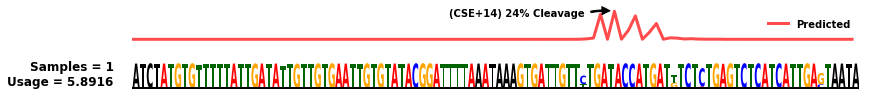

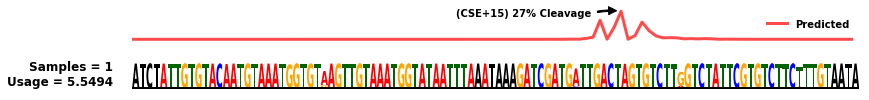

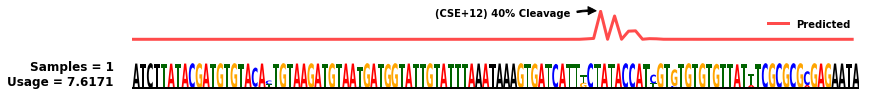

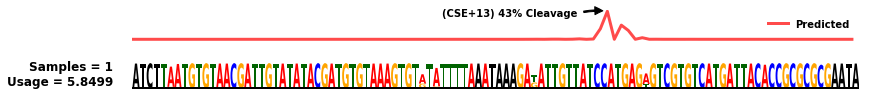

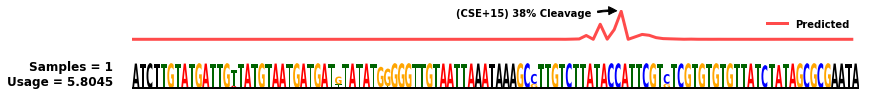

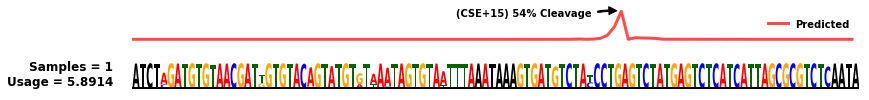

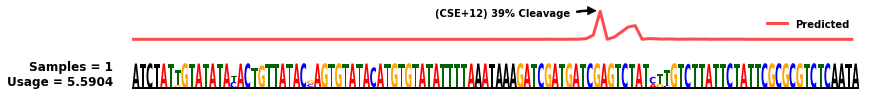

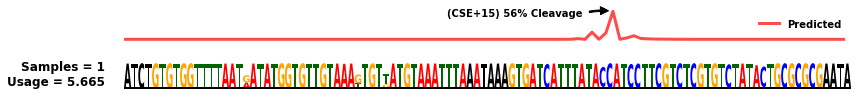

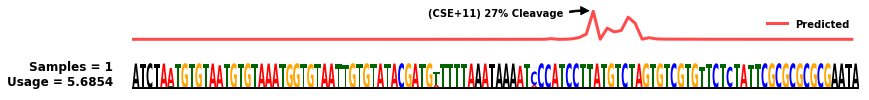

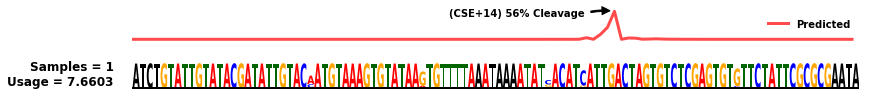

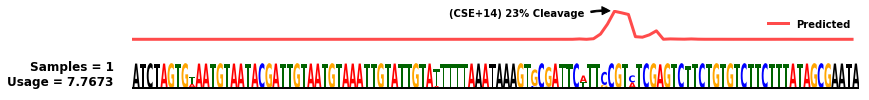

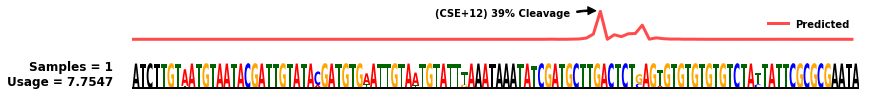

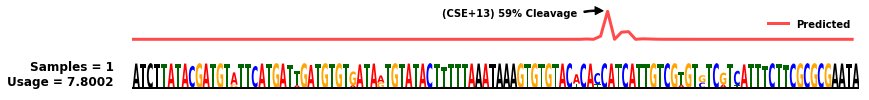

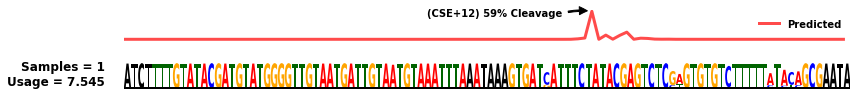

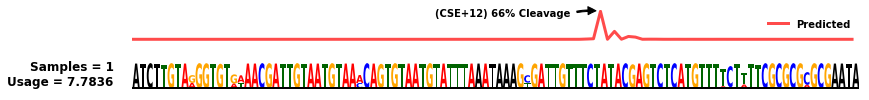

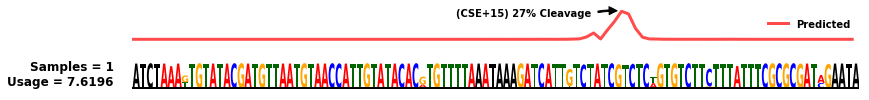

In [20]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Punish A-runs')

target_iso_logits = [6, 8]
picked_iso_logits = [0, 0]

min_logit_tol = 0.5

max_pwms = 8

for pwm_index in range(0, 3600) :
    
    sequence_template = sequence_templates[sequence_class[pwm_index, 0]]
    
    pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cut_pred[pwm_index, 0, :], axis=0)
    iso = np.expand_dims(iso_pred[pwm_index, 0, :], axis=0)#np.expand_dims(np.sum(cut[:, 80:115], axis=-1), axis=-1)
    
    target_logit = iso_logit[pwm_index, 0]
    
    pred_logit = np.log(iso / (1. - iso))
    
    if picked_iso_logits[pwm_index % 2] < max_pwms and np.abs(target_logit - pred_logit[0, 0]) < min_logit_tol :
        picked_iso_logits[pwm_index % 2] += 1
        
        plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='log', plot_start=70-49, plot_end=76+49, save_figs=True, fig_name='isoform_regression_genesis_target_logit_' + str(int(target_logit)) + "_pwm_index_" + str(pwm_index), fig_dpi=150)


In [8]:
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

In [9]:

logit_min = -3.5
logit_max = 5.5

isoform_start = 80
isoform_end = 115


In [10]:
#Helper function to get the conensus sequence from a PWM
def get_consensus_sequence(pwm) :
    consensus = ''
    
    for j in range(pwm.shape[0]) :
        nt_ix = np.argmax(pwm[j, :])
        
        if nt_ix == 0 :
            consensus += 'A'
        elif nt_ix == 1 :
            consensus += 'C'
        elif nt_ix == 2 :
            consensus += 'G'
        elif nt_ix == 3 :
            consensus += 'T'
    
    return consensus


n_sequences = 10000
n_sequences_ceil = int(n_sequences / 36) * 36 + 36

sequence_class = np.tile(np.array([[0]]), (n_sequences_ceil, 1))

noise_1 = np.random.uniform(-1, 1, (n_sequences_ceil, 100))
noise_2 = np.random.uniform(-1, 1, (n_sequences_ceil, 100))

target_logits = np.random.uniform(logit_min, logit_max, (n_sequences_ceil, 1))

pwms = []
consensus_seqs = []
onehot_seqs = []
iso_preds = []
cut_preds = []

onehot_encoder = isol.OneHotEncoder(205)

pred_outputs = predictor.predict([sequence_class, noise_1, noise_2, target_logits], batch_size=36)

_, _, _, optimized_pwm, _, _, _, _, _, _, _, iso_pred, cut_pred, _, _ = pred_outputs

optimized_pwm = np.expand_dims(optimized_pwm[:n_sequences, :, :, 0], axis=0)
cut_pred = cut_pred[:n_sequences, 0, :]

iso_pred = np.expand_dims(np.sum(cut_pred[:, isoform_start:isoform_end], axis=-1), axis=0)
cut_pred = np.expand_dims(cut_pred, axis=0)

pwms.append(optimized_pwm)
iso_preds.append(iso_pred)
cut_preds.append(cut_pred)

consensus_seqs.append([])
onehot_seqs.append([])
for i in range(n_sequences) :
    consensus_seqs[0].append(get_consensus_sequence(optimized_pwm[0, i, :, :]))
    onehot_seqs[0].append(onehot_encoder(get_consensus_sequence(optimized_pwm[0, i, :, :])))

consensus_seqs[0] = np.expand_dims(np.array(consensus_seqs[0], dtype=np.object), axis=0)
onehot_seqs[0] = np.expand_dims(onehot_seqs[0], axis=0)

pwms = np.concatenate(pwms, axis=0)
iso_preds = np.concatenate(iso_preds, axis=0)
cut_preds = np.concatenate(cut_preds, axis=0)
consensus_seqs = np.concatenate(consensus_seqs, axis=0)
onehot_seqs = np.concatenate(onehot_seqs, axis=0)

print('pwms.shape = ' + str(pwms.shape))
print('iso_preds.shape = ' + str(iso_preds.shape))
print('cut_preds.shape = ' + str(cut_preds.shape))
print('consensus_seqs.shape = ' + str(consensus_seqs.shape))
print('onehot_seqs.shape = ' + str(onehot_seqs.shape))

pwms.shape = (1, 10000, 205, 4)
iso_preds.shape = (1, 10000)
cut_preds.shape = (1, 10000, 206)
consensus_seqs.shape = (1, 10000)
onehot_seqs.shape = (1, 10000, 205, 4)


In [11]:

flat_onehot_seqs = np.reshape(onehot_seqs, (1 * n_sequences, 205 * 4))
flat_onehot_seqs_opt = flat_onehot_seqs[:, 24*4:124*4]
flat_onehot_seqs_dse = flat_onehot_seqs[:, 75*4:124*4]

target_logits_truncated = target_logits[:n_sequences, 0].reshape(1, -1)

logodds_preds = np.log(iso_preds / (1.0 - iso_preds))


n_unique_sequences = 10000


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


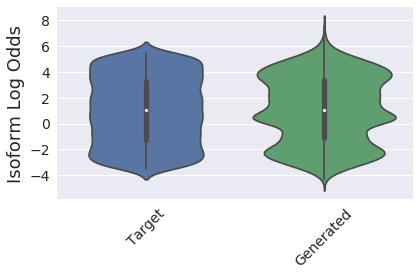

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 360x360 with 0 Axes>

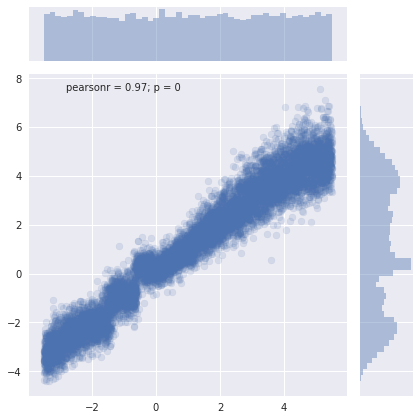

In [15]:
import seaborn as sns
sns.set()

#Uniquely generated sequences per objective

unique_count = len(np.unique(consensus_seqs[0, :]))

print('n_unique_sequences = ' + str(unique_count))


#Objective cut log odds violin plot

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=[target_logits_truncated, logodds_preds], axis=0)

plt.xticks(np.arange(2), ['Target', 'Generated'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.ylabel('Isoform Log Odds', fontsize=18)

plt.tight_layout()
#plt.savefig('genesis_cut_magnitude.png', transparent=True, dpi=70)
plt.show()


#Target vs. Engineered Isoform Log Odds

r_val, _ = pearsonr(np.ravel(target_logits_truncated), np.ravel(logodds_preds))

f = plt.figure(figsize=(5, 5))

#plt.scatter(np.ravel(target_logits_truncated), np.ravel(logodds_preds), color='black', s=5, alpha=0.5)
sns.jointplot(x=target_logits_truncated, y=logodds_preds, alpha=0.15, marginal_kws=dict(bins=50))
#plt.plot([logit_min, logit_max], [logit_min, logit_max], linewidth=3, color='darkgreen', linestyle='--')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.xlim(-4 - 1, 6 + 1)
#plt.ylim(-4 - 1, 6 + 1)

#plt.xlabel('Target Isoform (log)', fontsize=18)
#plt.ylabel('Generated Isoform (log)', fontsize=18)

#plt.title("R^2 = " + str(round(r_val * r_val, 2)), fontsize=18)

plt.tight_layout()

#fig_name = 'isoform_regression_genesis_scatter_density'
#plt.savefig(fig_name + '.png', transparent=True, dpi=150)
#plt.savefig(fig_name + '.svg')
#plt.savefig(fig_name + '.eps')

plt.show()



Starting PCA...
Done with PCA.
Starting tSNE...
Done with tSNE.


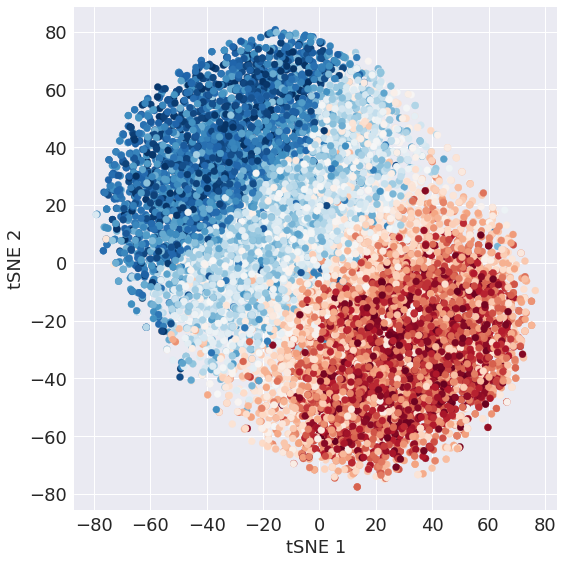

In [13]:
#PCA visualization, full sequence

print('Starting PCA...')

pca = PCA(n_components=50)
flat_onehot_seqs_pca = pca.fit_transform(flat_onehot_seqs_opt)

print('Done with PCA.')

#tSNE visualization

print('Starting tSNE...')

tsne = TSNE(n_components=2)
flat_onehot_seqs_tsne = tsne.fit_transform(flat_onehot_seqs_pca)

print('Done with tSNE.')

f = plt.figure(figsize = (8, 8))

plt.scatter(flat_onehot_seqs_tsne[:, 0], flat_onehot_seqs_tsne[:, 1], c=np.ravel(target_logits_truncated), cmap='RdBu_r', vmin=logit_min, vmax=logit_max)

plt.xlabel('tSNE 1', fontsize=18)
plt.ylabel('tSNE 2', fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()

#fig_name = 'isoform_regression_tsne_fullseq'
#plt.savefig(fig_name + '.png', transparent=True, dpi=150)
#plt.savefig(fig_name + '.svg')
#plt.savefig(fig_name + '.eps')

plt.show()
